---
# 알고리즘의 부정적 사례 시각화
---

## 시각화1
### `언론사별 정치성향`
데이터: `미디어_콘텐츠_이용행태조사_2023.xlsx`

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm,LinearSegmentedColormap

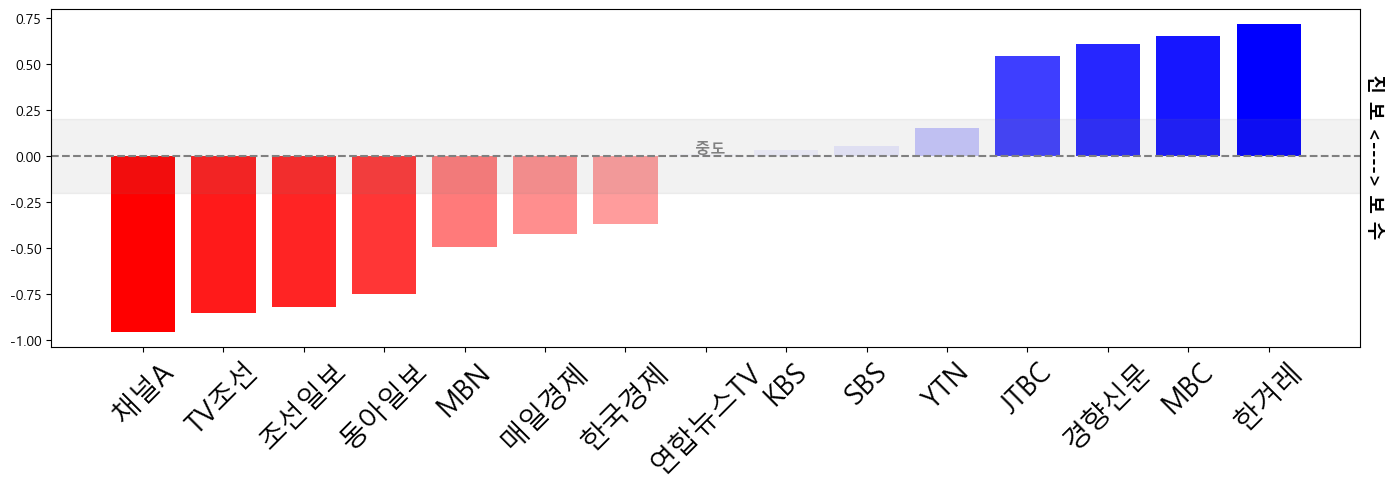

In [11]:
# 1. CSV 데이터 불러오기
df = pd.read_excel("C:\\Users\\chs02\\OneDrive\\바탕 화면\\현스기과제\\(2025) 3학년 1학기\\공모전\\데이터\\미디어_콘텐츠_이용행태조사_2023.xlsx")

# 2. 정치성향 재분류
political_map = {1: '보수', 2: '보수', 3: '중도', 4: '진보', 5: '진보'}
df['정치성향'] = df['Q15'].map(political_map)

# 3. Q6_1 ~ Q6_3 긴 형태로 변환 + 가중치 부여
df_long = df.melt(id_vars='정치성향', value_vars=['Q6_1', 'Q6_2', 'Q6_3'],
                  var_name='순위', value_name='언론사코드')
weight_map = {'Q6_1': 1.2, 'Q6_2': 1.0, 'Q6_3': 0.8}
df_long['가중치'] = df_long['순위'].map(weight_map)

# 4. 언론사 코드 → 이름 매핑
media_label_map = {
    1: "KBS", 2: "MBC", 3: "SBS", 4: "YTN", 5: "JTBC", 6: "TV조선", 7: "MBN", 8: "채널A",
    9: "연합뉴스TV", 10: "조선일보", 11: "중앙일보", 12: "동아일보", 13: "한국일보",
    14: "한국경제", 15: "매일경제", 16: "한겨레", 17: "경향신문", 18: "뉴스타파",
    19: "오마이뉴스", 20: "딴지일보", 21: "CBS", 22: "기타언론사"
}
df_long['언론사'] = df_long['언론사코드'].map(media_label_map)
df_long = df_long.dropna(subset=['정치성향', '언론사'])

# 5. '중도' 제외
df_long = df_long[df_long['정치성향'] != '중도']

# 6. 정치성향별 언론사 점수 합산
weighted_table = df_long.groupby(['정치성향', '언론사'])['가중치'].sum().unstack().fillna(0)

# 7. 상위 15개 언론사 기준
top15 = weighted_table.sum().sort_values(ascending=False).head(15).index
score_top15 = weighted_table[top15]

# 8. 비율 계산 (각 언론사 내 진보/보수 점수 비율)
total_weight = score_top15.sum()
score_ratio = score_top15.div(score_top15.sum(axis=0), axis=1).T  # 언론사 × 정치성향
score_ratio = score_ratio[['진보', '보수']]  # 순서 고정

# 9. 진보 - 보수 편차 계산
bias_score = score_ratio['진보'] - score_ratio['보수']
bias_score = bias_score.sort_values()

# 10. 색상 설정 (진보 우위: 파랑, 보수 우위: 빨강)
colorscale = ['red', 'white', 'blue']
cmap = LinearSegmentedColormap.from_list("custom_red_white_blue", colorscale)

norm = TwoSlopeNorm(vmin=bias_score.min(), vcenter=0, vmax=bias_score.max())
colors = [cmap(norm(val)) for val in bias_score]

# 11. 시각화
plt.figure(figsize=(14, 5))
plt.bar(bias_score.index, bias_score.values, color=colors)
plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("언론사")
plt.axhspan(-0.2, 0.2, color='gray', alpha=0.1)
# y값 범위에 맞게 텍스트 위치 설정
plt.text(len(bias_score) + 0.3, 0, "진 보 <----> 보 수", 
         fontsize=14, rotation=270, ha='center', va='center', fontweight='bold')


plt.text(len(bias_score) / 2 - 0.45, 0.02, "중도", fontsize=11, color='gray', ha='center',fontweight='bold')
plt.xticks(fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---
## 시각화2
### `이태원 참사 보도 주제별 언론사 편향성`
데이터: `이태원_참사_뉴스.xlsx`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [7]:
from matplotlib import font_manager, rc
font_path = "C:\\Windows\\Fonts\\malgun.ttf" # 폰트파일 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False 

In [12]:
# 1. CSV 데이터 불러오기
news_df = pd.read_excel("C:\\Users\\chs02\\OneDrive\\바탕 화면\\현스기과제\\(2025) 3학년 1학기\\공모전\\데이터\\이태원_참사_뉴스.xlsx")

# 2. 주요 언론사만 필터링
target_media = ['MBC', 'JTBC', 'YTN', '한겨레', '채널A', '조선일보', '한국경제', '매일경제', '동아일보']
filtered_news = news_df[news_df["source"].astype(str).apply(lambda x: any(media in x for media in target_media))]

# 3. 중도 제외
df_poli = filtered_news[filtered_news['polislant'] != '중도']

# 4. 성향별 전체 기사 수 계산
total_by_group = df_poli['polislant'].value_counts()

# 5. 주제별 진보/보수 기사 수 계산
topic_counts = df_poli.groupby(['polislant', 'topic']).size().unstack(fill_value=0)

# 6. 정규화: 전체 기사 수 기준
topic_prop = topic_counts.div(total_by_group, axis=0)

# 7. 편향 점수 계산 (보수 - 진보)
bias_score = topic_prop.loc['보수'] - topic_prop.loc['진보']
bias_score = bias_score.sort_values()

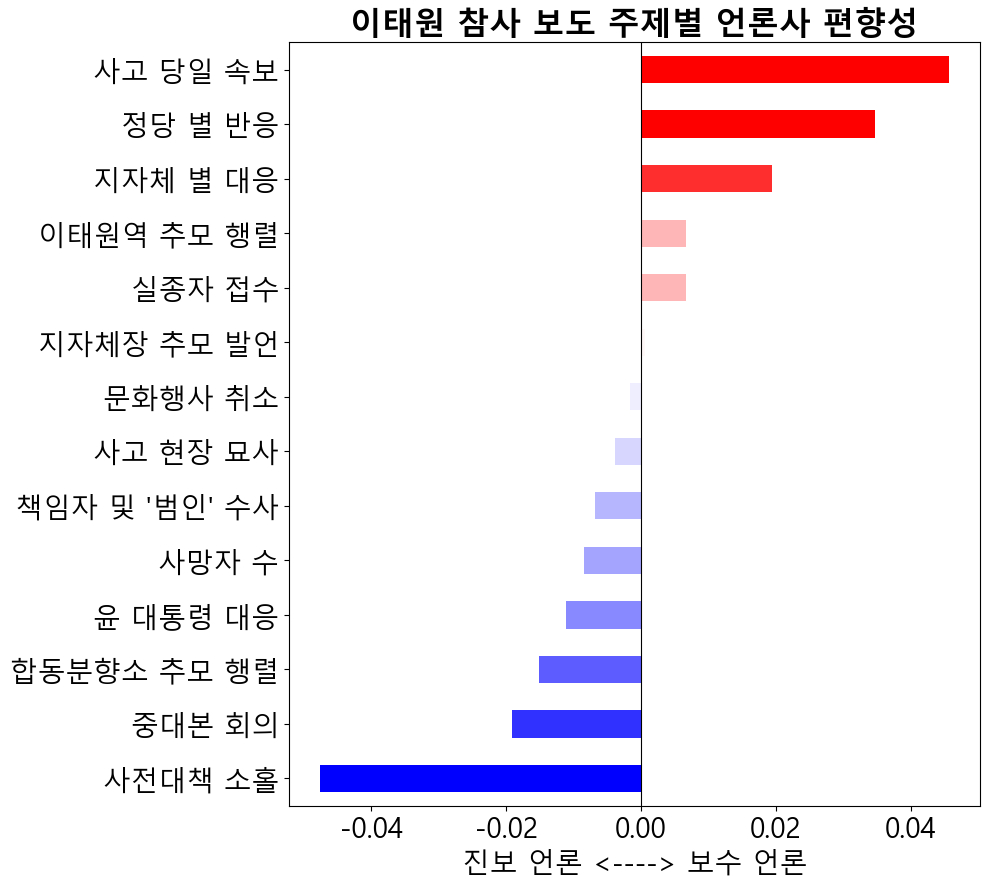

In [13]:
# 8. 색상: 빨강-흰색-파랑 그라데이션
colorscale = ['blue', 'white','red']
cmap = LinearSegmentedColormap.from_list("custom_rwb", colorscale)

bias_margin = bias_score.abs().max()*0.5

norm = TwoSlopeNorm(vmin=-bias_margin, vcenter=0, vmax=bias_margin)
colors = [cmap(norm(val)) for val in bias_score]

# 9. 시각화
plt.figure(figsize=(10, 9))
bias_score.plot(kind='barh', color=colors)

plt.axvline(0, color='black', linewidth=0.8)
plt.title("이태원 참사 보도 주제별 언론사 편향성", fontsize=23, fontweight='bold')
plt.xlabel("진보 언론 <----> 보수 언론", fontsize=20)
plt.ylabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

---
## 시각화3
### `이태원 참사 관련 극성 유튜브 채널 제목 비교`
데이터: `youtube.title2.xlsx`

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from PIL import Image, ImageOps
import os

진보 텍스트 길이: 2490 / 보수 텍스트 길이: 3389


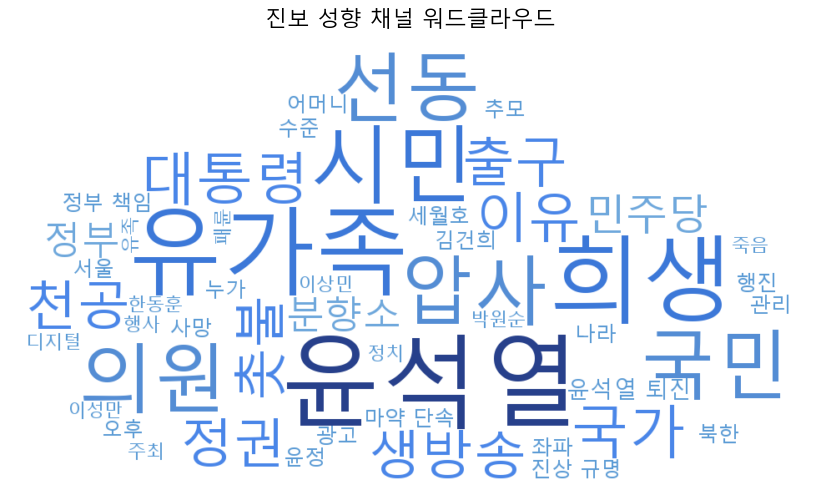

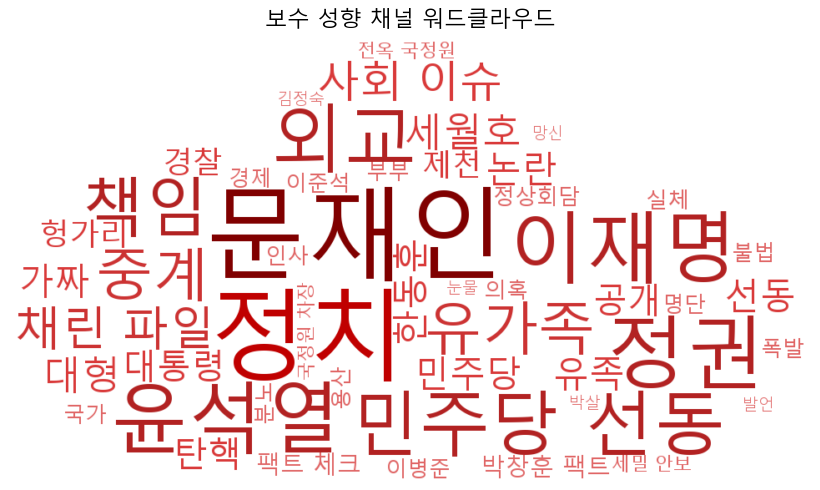

In [4]:
# ========= 1) 파일 경로 =========
EXCEL_PATH = r"C:\\Users\\chs02\\OneDrive\\바탕 화면\\현스기과제\\(2025) 3학년 1학기\\공모전\\데이터\\부정적\\youtube.title2.xlsx"
MASK_PATH = r"C:\\Users\\chs02\\OneDrive\\바탕 화면\\현스기과제\\(2025) 3학년 1학기\\공모전\\데이터\\cloud.webp"

# ========= 2) 데이터 로드 =========
title = pd.read_excel(EXCEL_PATH, header=0)

# ========= 3) 성향 분류 =========
conservative = ['신의 한수', '황장수의뉴스브리핑o']
progressive  = ['서울의소리 VoiceOfSeoul', '유재일']
title['성향'] = title['채널명'].apply(lambda x: '진보' if x in progressive else ('보수' if x in conservative else '기타'))

# ========= 4) 마스크 정규화 =========
def make_mask(path):
    img = Image.open(path)
    if img.mode in ('RGBA', 'LA'):
        bg = Image.new("RGBA", img.size, "WHITE")
        img = Image.alpha_composite(bg, img).convert("L")
    else:
        img = img.convert("L")

    # 검정(어두움) 픽셀을 '허용(흰색)'으로 선택
    arr = np.array(img)
    mask = (arr > 200).astype(np.uint8) * 255   # ← 부등호만 바꿈 (반전 제거)

    return mask


cloud_mask = make_mask(MASK_PATH)

# ========= 5) 불용어 (사용자 작성 버전 그대로) =========
stopwords = set([
    # 기존
    "영상", "뉴스", "기자", "방송", "합니다", "입니다", "한다", "있는", "없는", "대한", "관련", "이번",
    "했다", "에서", "으로", "그리고", "것", "수", "더", "중", "등", "위해", "또는", "한다는", "라고",
    "지난", "했다는", "따라", "참사", "현장", "충격", "긴급", "속보", "직접", "직설", "폭로", "사건",
    "실황", "보도", "유튜브", "녹화", "라이브", "출연", "인터뷰", "기자회견", "일자", "앵커", "채널",
    "진행", "금요일", "화요일", "2023", "2024",
    # 채널명 및 일반적 단어
    "한수", "신의", "김어준", "뉴스공장", "진성호", "겸손", "힘들다", "공장", "오늘", "이번", "내일",
    "대한민국", "당시", "상황", "현재", "모습", "때문", "경우", "최근", "시간", "정도", "대한", "내용",
    "관련", "부분", "진짜", "등등",
    # 기타 불용 명사
    "자신", "우리", "모두", "이후", "정리", "분석", "대해", "이야기", "보니", "이태원", "사고",
    "우동균", "신의한수"
])

# ========= 6) 형태소 분석 =========
okt = Okt()

def to_tokens(series):
    series = series.dropna().astype(str)
    tokens = []
    
    for s in series:
        tokens.extend([w for w in okt.nouns(s) if len(w) > 1 and w not in stopwords])
    return " ".join(tokens)

text_jinbo = to_tokens(title.loc[title['성향']=='진보', '영상 제목'])
text_bosu  = to_tokens(title.loc[title['성향']=='보수', '영상 제목'])

print(f"진보 텍스트 길이: {len(text_jinbo)} / 보수 텍스트 길이: {len(text_bosu)}")

# ========= 7) 색상 팔레트 =========
def make_color_func(colors):
    def color_func(word, font_size, *args, **kwargs):
        ratio = (font_size - 10) / (120 - 10)
        idx = max(0, min(len(colors)-1, int(ratio * (len(colors)-1))))
        return colors[idx]
    return color_func

jinbo_colors = ["#5B9BD5","#6FA8DC","#4A86E8","#548DD4","#3C78D8","#27408B"]
bosu_colors  = ["#E06666","#D93A3A","#CC3333","#B22222","#C00000","#800000"]

# ========= 8) 워드클라우드 =========
FONT_PATH = r"C:\Windows\Fonts\malgun.ttf"
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def show_wc(text, title_txt, color_func, mask=None):
    wc = WordCloud(
        font_path=FONT_PATH,
        background_color='white',
        width=800, height=400,
        max_words=50, min_font_size=10, max_font_size=120,
        mask=mask, color_func=color_func
    ).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title_txt, fontsize=16)
    plt.tight_layout()
    plt.show()

# ========= 9) 실행 =========
show_wc(text_jinbo, "진보 성향 채널 워드클라우드", make_color_func(jinbo_colors), mask=cloud_mask)
show_wc(text_bosu,  "보수 성향 채널 워드클라우드",  make_color_func(bosu_colors),  mask=cloud_mask)
